In [ ]:
!python -m pip install -qq kaggle                                               # install kaggle

In [ ]:
%%bash
mkdir ~/.kaggle                                                                 # make directory
cp kaggle.json ~/.kaggle/                                                       # copy file (json)
chmod 600 ~/.kaggle/kaggle.json                                                 # change file permission
kaggle datasets download praneshkumarm/multidiseasedataset                      # download dataset
unzip -qq "/content/multidiseasedataset.zip"                                    # unzip data
mv "Augumented Data" "augumented_data"                                          # rename data folder
rm -rf "/content/sample_data"                                                   # remove sample data

mkdir: cannot create directory ‘/root/.kaggle’: File exists
100%|██████████| 2.88G/2.88G [00:25<00:00, 123MB/s]


In [ ]:
import os
import re
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf                                                         # load tensorflow
import tensorflow_datasets as tfds
import pandas as pd

In [ ]:
classes=os.listdir('augumented_data')                                                  # get all classes names
print('Total classes:',len(classes))                                            # total classes
print('Class names:',classes)                                                   # class names
# clean class names
classes_clean=[re.sub('[^A-Za-z0-9 ]',' ',class_) for class_ in classes]        # remove unwanted characters
classes_clean=[re.sub('[ ]+','_',class_).casefold() for class_ in classes_clean]# replace one or multiple spaces by underscore '_'
print('Cleaned Class names:',classes_clean)                                     # clean class names
# rename class names with clean class names
for old_name,new_name in zip(classes,classes_clean):                            # get old and new class names
  os.rename(os.path.join('augumented_data',old_name),os.path.join('augumented_data',new_name))# rename with new class names
# get minimum class count ------------------------------------------------------
class_counts:dict=dict()                                                        # get class samples for each class
# get number of files in each class
for class_ in os.listdir('augumented_data'):                                           # get class name folder
  class_counts[class_]=len(os.listdir(os.path.join('augumented_data',class_)))         # count samples in given class
print('Class counts:',class_counts)                                             # print class counts
minimum_class_count=min(class_counts.values())                                  # get minimum class count
test_split_size:int=int(minimum_class_count*10/100)                             # get test split size
# make train and test directory
os.mkdir('test')                                                                # make directory to store test data

Total classes: 28
Class names: ['Chest - Covid19', 'Skin - bkl', 'Brain - No  Brain Tumor', 'Chest - Pneumonia', 'RF - Proliferate DR', 'Brain - pituitary Brain Tumor', 'Brain - Alzheimer ModerateDemented', 'RF - Normal Fundus', 'Brain - Alzheimer VeryMildDemented', 'RF - Cataract', 'Skin - bcc', 'Skin - akiec', 'Skin - vasc', 'Brain - Alzheimer NonDemented', 'Chest - Lung Opacity', 'Brain - glioma Brain Tumor', 'RF - Mild DR', 'RF - Glaucoma', 'RF - AMD', 'RF - Hypertensive Retinopathy', 'Brain - Alzheimer MildDemented', 'Chest - Normal', 'Brain - meningioma Brain Tumor', 'Skin - df', 'RF - Severe DR', 'Skin - nv', 'Skin - mel', 'RF - Moderate DR']
Cleaned Class names: ['chest_covid19', 'skin_bkl', 'brain_no_brain_tumor', 'chest_pneumonia', 'rf_proliferate_dr', 'brain_pituitary_brain_tumor', 'brain_alzheimer_moderatedemented', 'rf_normal_fundus', 'brain_alzheimer_verymilddemented', 'rf_cataract', 'skin_bcc', 'skin_akiec', 'skin_vasc', 'brain_alzheimer_nondemented', 'chest_lung_opacity

In [ ]:
# move 10% of minimum class count from each directory
for class_ in os.listdir('augumented_data'):
  os.mkdir(os.path.join('test',class_))
  #make move randomly selected images from main to test directory
  for image in np.random.choice(os.listdir(os.path.join('augumented_data',class_)),size=test_split_size,replace=False):
    os.rename(os.path.join('augumented_data',class_,image),os.path.join('test',class_,image))
os.rename('augumented_data','train')                                            # rename main directory as train

In [ ]:
#load dataset - train,test and valid
train=tf.keras.utils.image_dataset_from_directory('train',labels='inferred',label_mode='int',class_names=None,color_mode='rgb',batch_size=64,
                                                   image_size=(224,224),shuffle=True,validation_split=0.3,interpolation='bilinear',
                                                   subset='training',seed=8,)
valid=tf.keras.utils.image_dataset_from_directory('train',labels='inferred',label_mode='int',class_names=None,color_mode='rgb',batch_size=64,
                                                   image_size=(224,224),shuffle=True,validation_split=0.3,interpolation='bilinear',
                                                   subset='validation',seed=8,)
test=tf.keras.utils.image_dataset_from_directory('test',labels='inferred',label_mode='int',class_names=None,color_mode='rgb',batch_size=64,
                                                   image_size=(224,224),shuffle=True,validation_split=0.0,interpolation='bilinear',
                                                   subset=None
                                                  ,seed=8,)

Found 42819 files belonging to 28 classes.
Using 29974 files for training.
Found 42819 files belonging to 28 classes.
Using 12845 files for validation.
Found 2940 files belonging to 28 classes.


In [ ]:
print("Total training images:",train.cardinality()*32)
print("Total validation images:",valid.cardinality()*32)
print("Total test images:",test.cardinality()*32)
training_classes:list=train.class_names
valid_classes:list=valid.class_names
test_classes:list=test.class_names
assert training_classes==valid_classes==test_classes,'class count train, valid and test set is not same '
print('Class names:',training_classes)

Total training images: tf.Tensor(15008, shape=(), dtype=int64)
Total validation images: tf.Tensor(6432, shape=(), dtype=int64)
Total test images: tf.Tensor(1472, shape=(), dtype=int64)
Class names: ['brain_alzheimer_milddemented', 'brain_alzheimer_moderatedemented', 'brain_alzheimer_nondemented', 'brain_alzheimer_verymilddemented', 'brain_glioma_brain_tumor', 'brain_meningioma_brain_tumor', 'brain_no_brain_tumor', 'brain_pituitary_brain_tumor', 'chest_covid19', 'chest_lung_opacity', 'chest_normal', 'chest_pneumonia', 'rf_amd', 'rf_cataract', 'rf_glaucoma', 'rf_hypertensive_retinopathy', 'rf_mild_dr', 'rf_moderate_dr', 'rf_normal_fundus', 'rf_proliferate_dr', 'rf_severe_dr', 'skin_akiec', 'skin_bcc', 'skin_bkl', 'skin_df', 'skin_mel', 'skin_nv', 'skin_vasc']


In [ ]:
# make plot data
for image,labels in train.take(1):break
image_to_plot:int=9
plt.figure(figsize=(15,15))
for index in range(9):
  plt.subplot(3,3,index+1)
  plt.imshow(image[index].numpy().astype('uint8'))
  plt.axis('off')
  plt.title(training_classes[labels[index].numpy()])
plt.tight_layout()
plt.show()

In [ ]:
base_model=tf.keras.applications.VGG16(include_top=False,weights='imagenet',input_shape=(224,224,3))# laod base model - VGG16
#base_model.summary(line_length=120,positions=None,print_fn=None,expand_nested=True,show_trainable=False,layer_range=None)# print base model summary
base_model.trainable=False                                                      # make freeze base

58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
inputs=tf.keras.layers.Input(shape=(224,224,3),batch_size=None,name='model_inputs')# add input layer
model_x=tf.keras.layers.Rescaling(1/255,offset=0.0,name='rescaler')(inputs)     # rescale inputs
model_x=base_model(model_x)                                                     # feed inputs to base model
model_x=tf.keras.layers.Flatten(name='flatten')(model_x)                         # make flatten outputs
model_x=tf.keras.layers.Dense(1024,activation='relu')(model_x)                  # apply dense layer
outputs=tf.keras.layers.Dense(len(training_classes),activation='softmax')(model_x)# output layer
model=tf.keras.Model(inputs=[inputs],outputs=[outputs],name='custom_vgg16')     # build model
model.summary(line_length=120,positions=None,print_fn=None,expand_nested=True,show_trainable=True,layer_range=None)# print model summary

Model: "custom_vgg16"
___________________________________________________________________________________________________________________________________
 Layer (type)                                         Output Shape                                    Param #           Trainable  
 model_inputs (InputLayer)                            [(None, 224, 224, 3)]                           0                 Y          
                                                                                                                                   
 rescaler (Rescaling)                                 (None, 224, 224, 3)                             0                 Y          
                                                                                                                                   
 vgg16 (Functional)                                   (None, 7, 7, 512)                               14714688          N          
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯

In [ ]:
#make compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=tf.keras.metrics.SparseCategoricalAccuracy())

In [ ]:
# make early stopping
early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy',min_delta=0,patience=5,verbose=1,mode='auto',restore_best_weights=True)
# make train model
history=model.fit(train,batch_size=None,epochs=10_000,verbose=2,callbacks=[early_stop],validation_split=0,validation_data=valid,shuffle=True)

Epoch 1/10000
469/469 - 203s - loss: 1.1394 - sparse_categorical_accuracy: 0.6151 - val_loss: 0.7823 - val_sparse_categorical_accuracy: 0.6908 - 203s/epoch - 433ms/step
Epoch 2/10000
469/469 - 179s - loss: 0.6182 - sparse_categorical_accuracy: 0.7508 - val_loss: 0.6513 - val_sparse_categorical_accuracy: 0.7375 - 179s/epoch - 381ms/step
Epoch 3/10000
469/469 - 179s - loss: 0.5128 - sparse_categorical_accuracy: 0.7943 - val_loss: 0.5636 - val_sparse_categorical_accuracy: 0.7717 - 179s/epoch - 383ms/step
Epoch 4/10000
469/469 - 178s - loss: 0.4383 - sparse_categorical_accuracy: 0.8209 - val_loss: 0.6705 - val_sparse_categorical_accuracy: 0.7467 - 178s/epoch - 379ms/step
Epoch 5/10000
469/469 - 178s - loss: 0.3784 - sparse_categorical_accuracy: 0.8487 - val_loss: 0.6011 - val_sparse_categorical_accuracy: 0.7703 - 178s/epoch - 379ms/step
Epoch 6/10000
469/469 - 178s - loss: 0.3240 - sparse_categorical_accuracy: 0.8700 - val_loss: 0.6311 - val_sparse_categorical_accuracy: 0.7701 - 178s/epoch

In [ ]:
# see model history (first five epoches)
pd.DataFrame(history.history).head()

,loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy
0,1.139446,0.615066,0.782266,0.690775
1,0.618180,0.750784,0.651316,0.737485
2,0.512814,0.794255,0.563639,0.771740
3,0.438311,0.820878,0.670523,0.746750
4,0.378437,0.848702,0.601149,0.770339


In [ ]:
# see model history (last five epoches)
pd.DataFrame(history.history).tail()

,loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy
17,0.111520,0.959432,0.812053,0.800311
18,0.135323,0.950757,0.822554,0.804749
19,0.076122,0.972977,0.863118,0.803425
20,0.080874,0.970541,0.877004,0.806929
21,0.081434,0.972009,0.838639,0.801323


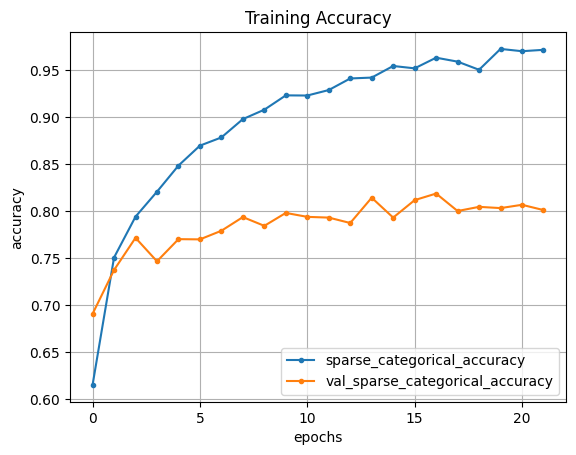

In [ ]:
# make plot training accuracy and validation accuracy
pd.DataFrame(history.history)[['sparse_categorical_accuracy','val_sparse_categorical_accuracy']].plot(marker='.')# make plot
plt.grid(),plt.title('Training Accuracy'),plt.xlabel('epochs'),plt.ylabel('accuracy')# add grid, title and axis labels
plt.show()                                                                      # make plot show

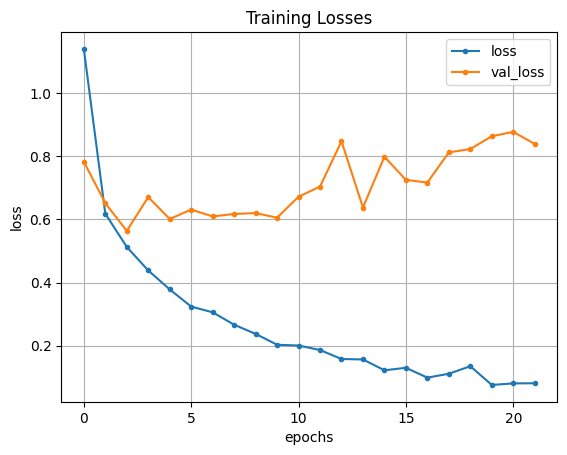

In [ ]:
# make plot training losses and validation losses
pd.DataFrame(history.history)[['loss','val_loss']].plot(marker='.')             # make plot
plt.grid(),plt.title('Training Losses'),plt.xlabel('epochs'),plt.ylabel('loss') # add grid, title and axis labels
plt.show()                                                                      # make plot show

In [ ]:
# evaluate model
results=model.evaluate(test,batch_size=None,verbose="auto",sample_weight=None,return_dict=True)
print('Testing results:',results)                                               # make print results

46/46 [==============================] - 22s 447ms/step - loss: 0.7573 - sparse_categorical_accuracy: 0.8245
Testing results: {'loss': 0.7572985887527466, 'sparse_categorical_accuracy': 0.8244897723197937}


In [ ]:
# make save model (weights and configuration)
model.save('augumented_data_classifier',overwrite=True,save_format=None)               # make save

In [ ]:
!zip -r -qq "augumented_data.zip" "augumented_data_classifier"                     # make zip model
# make auto download model weights
from google.colab import files                                                  # load file class
files.download('augumented_data.zip')                                       # download model zip file